In [1]:
import pandas as pd
import re

# Import Data

## Fact Check Data

In [14]:
fakenews = pd.read_json("C:\\Users\\gyiko\\OneDrive - personalmicrosoftsoftware.uci.edu\\STATS\\STATS 170AB\\Project\\datasets\\factcheck\\FactCheckData_clean_mini.json")

In [15]:
en_news = fakenews[fakenews['language']=='en'].reset_index(drop=True)

In [16]:
en_news = en_news.drop(columns=['author_type','url','rating_type','rating','dataFeedElement','language'])

In [31]:
len(en_news)

3918

## Reddit Comments Data

In [6]:
reddit_data = pd.read_json("C:\\Users\\gyiko\\OneDrive - personalmicrosoftsoftware.uci.edu\\STATS\\STATS 170AB\\Project\\datasets\\fake_news_reddit_cikm20.json")

In [7]:
df = reddit_data.drop(columns=['label','reddit_comments','researched_by','url'])

In [8]:
len(reddit_data.text.values.tolist())

69396

# Tokenization

In [18]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'claim', 'http', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [19]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = en_news.text.values.tolist()
data_words = list(sent_to_words(data))

## POS

In [20]:
from gensim.utils import simple_preprocess
import spacy

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en_core_web_sm  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [ ]:
data_ready[0]

# LDA

In [21]:
import gensim
import gensim.corpora as corpora

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [39]:
num_topics = 9

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [40]:
lda_model.print_topics()

[(0,
  '0.039*"people" + 0.023*"hotel" + 0.022*"fire" + 0.021*"new" + 0.017*"mp" + 0.016*"china" + 0.016*"minister" + 0.015*"die" + 0.014*"body" + 0.014*"dead"'),
 (1,
  '0.032*"child" + 0.030*"work" + 0.029*"delhi" + 0.027*"tamil_nadu" + 0.027*"baby" + 0.023*"arrest" + 0.021*"help" + 0.021*"comment" + 0.020*"burn" + 0.018*"ireland"'),
 (2,
  '0.060*"india" + 0.040*"temple" + 0.029*"give" + 0.024*"country" + 0.016*"party" + 0.016*"railway_station" + 0.015*"ever" + 0.014*"demolish" + 0.013*"fact" + 0.013*"place"'),
 (3,
  '0.035*"show" + 0.031*"support" + 0.027*"viral" + 0.026*"raja" + 0.025*"photo" + 0.024*"officer" + 0.022*"high" + 0.021*"case" + 0.020*"accuse" + 0.019*"government"'),
 (4,
  '0.029*"day" + 0.027*"hindu" + 0.027*"put" + 0.026*"recent" + 0.026*"law" + 0.023*"ukraine" + 0.022*"pakistan" + 0.018*"rally" + 0.017*"hold" + 0.016*"ayodhya"'),
 (5,
  '0.114*"student" + 0.026*"ramadoss" + 0.020*"vehicle" + 0.019*"university" + 0.018*"political" + 0.016*"criminal" + 0.015*"criti

# Visualization

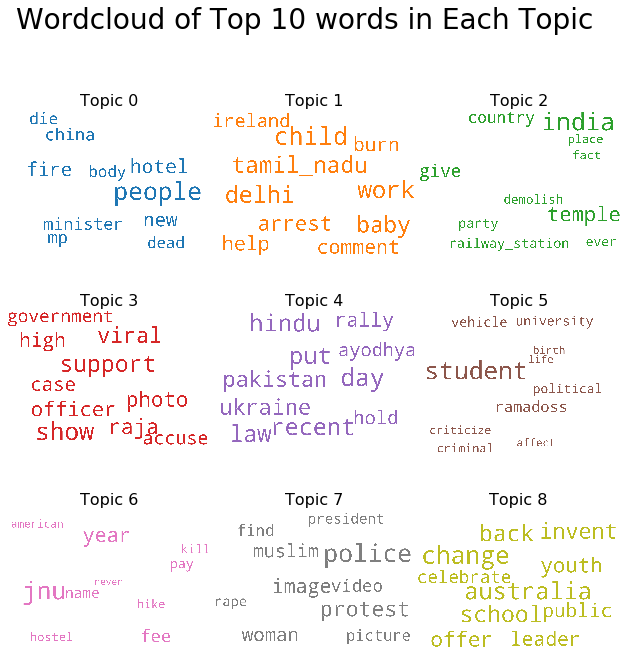

In [64]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(11,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.suptitle('Wordcloud of Top 10 words in Each Topic',size=28)
plt.show()

# Topic Assignment

In [60]:
# Get topics for each row

Dominant_Topic = []
Perc_Contribution = []



for i in corpus:
    temp = sorted(lda_model[i][0], reverse=True, key=lambda x: x[1])[0]
    Dominant_Topic.append(temp[0])
    Perc_Contribution.append(temp[1])

en_news.assign(Dominant_Topic=Dominant_Topic,Topic_Perception = Perc_Contribution)

,text,date,author,Dominant_Topic,Topic_Perception
0,Valenzuela City is part of Bulacan province.,2021-03-12,Vera Files,1,0.408697
1,Returning overseas Filipino workers (OFWs) and...,2021-03-12,Vera Files,0,0.480617
2,A photo shows a vehicle driving through war-to...,2021-03-12,Vera Files,3,0.448670
3,Photo of the truck carrying an anti-Congress m...,2021-03-11,FACTLY,7,0.440980
4,Video shows Rahul Gandhi saying that Mahatma G...,2021-03-11,FACTLY,3,0.351971
...,...,...,...,...,...
3913,"DUP MPs voted against a pay rise for nurses, f...",2019-11-15,Fact Check NI,3,0.373773
3914,"“My name itself is a problem, Vappichi” : IIT ...",2019-11-15,The South Asian Express,5,0.649576
3915,Claim cops manhandling woman over traffic chal...,2019-11-14,Fact Crescendo,7,0.872981
3916,Claim Bhagavad Gita made compulsory for Dutch ...,2019-11-14,Fact Crescendo,8,0.351079
